# MNIST Attack

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchsummary import summary
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from IPython.display import clear_output

%matplotlib inline

## Building the Classifier

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,  5, 5),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(5, 15, 3),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(375, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.BatchNorm1d(10),
            nn.LogSoftmax()
        )
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(-1, 375)
        out = self.classifier(out)
        return out



In [3]:
trans = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

train_set = MNIST(root='./data', train=True,  transform=trans, download=True)
test_set  = MNIST(root='./data', train=False, transform=trans, download=True)

In [4]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False
)

In [5]:
model = ConvNet()
model

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(5, 15, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=375, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LogSoftmax()
  )
)

In [6]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 24, 24]             130
       BatchNorm2d-2            [-1, 5, 24, 24]              10
              ReLU-3            [-1, 5, 24, 24]               0
         MaxPool2d-4            [-1, 5, 12, 12]               0
            Conv2d-5           [-1, 15, 10, 10]             690
       BatchNorm2d-6           [-1, 15, 10, 10]              30
              ReLU-7           [-1, 15, 10, 10]               0
         MaxPool2d-8             [-1, 15, 5, 5]               0
            Linear-9                   [-1, 64]          24,064
      BatchNorm1d-10                   [-1, 64]             128
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
      BatchNorm1d-13                   [-1, 10]              20
       LogSoftmax-14                   

/usr/local/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [7]:
optimizer     = optim.Adadelta(model.parameters())
loss_function = nn.NLLLoss()

In [8]:
for i in range(5):
    #training loop
    mean_loss = 0.
    for j, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        mean_loss = mean_loss + (loss.item() - mean_loss) / float(j + 1)
    print(mean_loss, end='\t')
    #testing loop
    mean_loss = 0.
    for j, (x, y) in enumerate(test_loader):
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        mean_loss = mean_loss + (loss.item() - mean_loss) / float(j + 1)
    print(mean_loss)

/usr/local/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.3004311100733765	0.11384217215403929
0.11329270881904915	0.07346168430391695
0.08845808797727035	0.054495938873616985
0.072755469203197	0.044980158833693745
0.06539093052251273	0.03787009486714374


## Building Attack

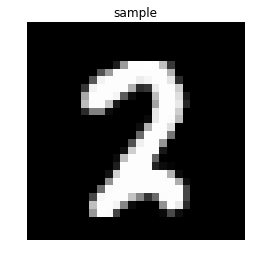

In [352]:
sample = x[1].detach().numpy()[0]

plt.title("sample")
plt.axis('off')
plt.imshow(sample, cmap='gray')
plt.show()

In [353]:
adversarial_model = deepcopy(model)

residual = torch.rand(x.shape)
residual = (residual + residual.min()) / (residual.max() * 100.)
residual.requires_grad = True
print(residual[0][0][0][0])

pred = adversarial_model(x + residual)
pred.argmax(1), y

tensor(1.00000e-03 *
       5.1698)


/usr/local/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,
          5,  6]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,
          5,  6]))

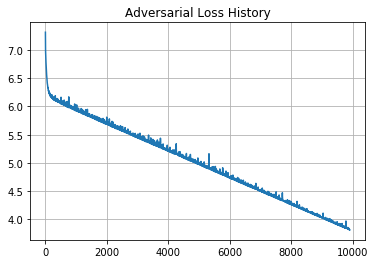

last loss value :  3.813765525817871


In [355]:
aversarial_loss = nn.NLLLoss()
adversarial_optimizer = optim.SGD([residual], lr=100)

adv_loss_history = []
for i in range(10000):
    pred = adversarial_model((x + nn.Sigmoid()(residual)) / 2.)
    adversarial_optimizer.zero_grad()
    #adversarial loss computation
    adv_loss  = (2 - i / 10000) * aversarial_loss(pred, torch.LongTensor([0] * 16)) #class transfert
    adv_loss += 5 * nn.MSELoss()((x + nn.Sigmoid()(residual)) / 2., x)   #disformation should not be too big 
    adv_loss += .0001 * nn.Sigmoid()(residual).abs().sum()               #L1 regularization on the noize
    adv_loss += .5 * nn.MSELoss()(residual, torch.zeros(residual.shape)) #L2 regularization on the noize
    adv_loss.backward()
    adversarial_optimizer.step()
    adv_loss_history.append(adv_loss.item())
    if not i % 100:
        clear_output()
        plt.title("Adversarial Loss History")
        plt.plot(adv_loss_history)
        plt.grid()
        plt.show()
        print("last loss value : ", adv_loss_history[-1])

In [356]:
pred = adversarial_model(x + nn.Sigmoid()(residual))
pred.argmax(1), y

/usr/local/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(tensor([ 9,  1,  1,  9,  8,  1,  1,  4,  1,  9,  1,  1,  1,  1,
          9,  1]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,
          5,  6]))

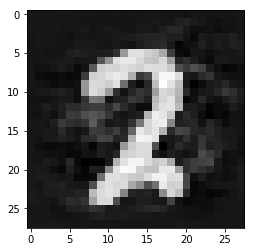

In [357]:
plt.imshow(((x + nn.Sigmoid()(residual))[1] / 2.).detach().numpy()[0], cmap='gray')
plt.show()

In [358]:
nn.Sigmoid()(residual).min(), nn.Sigmoid()(residual).max()

(tensor(0.1015), tensor(0.8237))

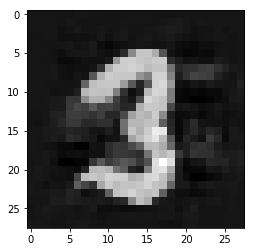

In [359]:
plt.imshow(((x + nn.Sigmoid()(residual))[2] / 2.).detach().numpy()[0], cmap='gray')
plt.show()

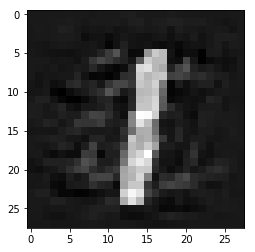

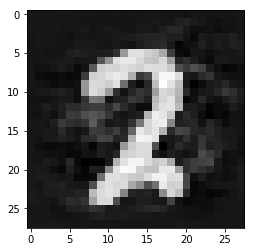

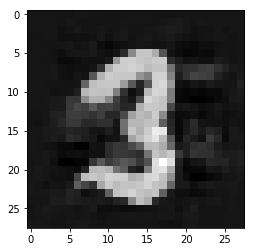

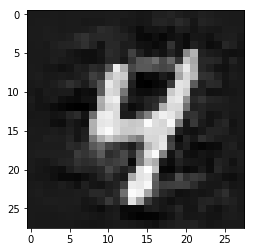

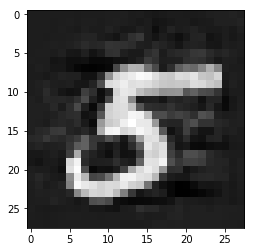

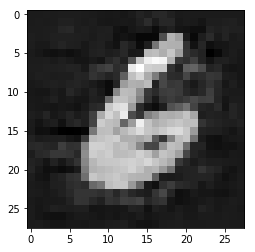

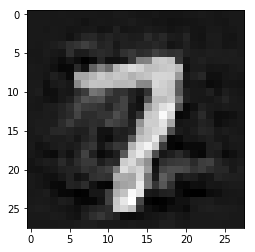

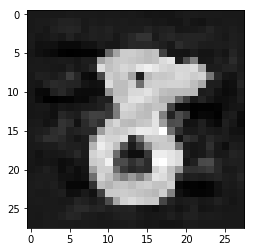

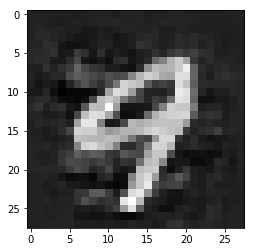

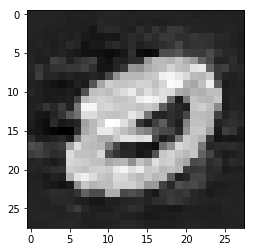

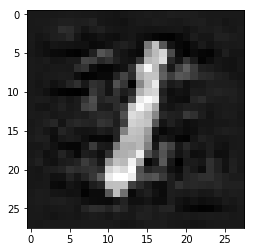

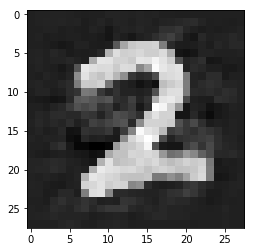

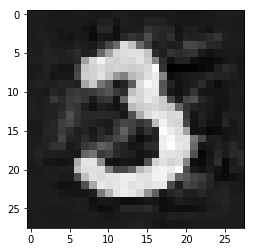

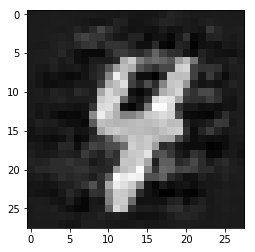

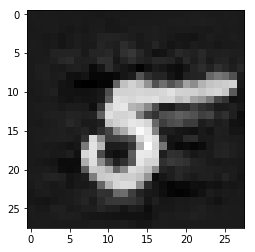

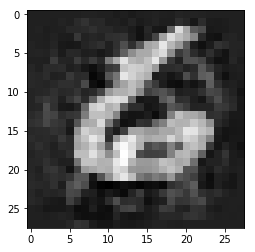

In [360]:
for i in range(16):
    plt.imshow(((x + nn.Sigmoid()(residual))[i] / 2).detach().numpy()[0], cmap='gray')
    plt.show()